In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api as sm
import itertools
import random
import sklearn.metrics as skmetrics
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA 
from tqdm import tqdm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('zillow-carlifornia.csv', parse_dates=True)
df_test = pd.read_csv('test.csv', parse_dates=True)
df_train.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [3]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Month'] = pd.to_datetime(df_test['Month'])

In [4]:
# split df_train
history,test = df_train[df_train.Date<'2016-01-01'], df_train[df_train.Date>='2016-01-01']
test.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
95,2016-01-31,NaN,3.91,5.0
96,2016-02-29,NaN,3.96,4.9
97,2016-03-31,NaN,3.60,5.0
98,2016-04-30,NaN,3.60,5.0
99,2016-05-31,NaN,3.59,4.8


In [5]:
test.loc[:,'MedianSoldPrice_AllHomes.California'] = df_test['Median House Price'].values
test.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
95,2016-01-31,476250,3.91,5.0
96,2016-02-29,466000,3.96,4.9
97,2016-03-31,485000,3.60,5.0
98,2016-04-30,501000,3.60,5.0
99,2016-05-31,501000,3.59,4.8


# Initial Explore

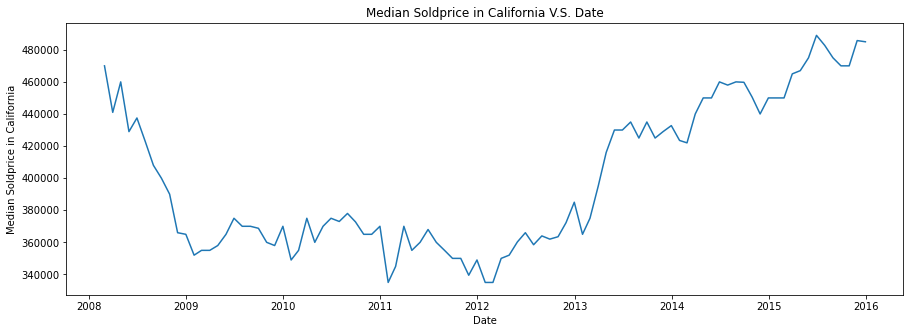

In [6]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(history.Date, history['MedianSoldPrice_AllHomes.California'])
plt.xlabel("Date")
plt.ylabel("Median Soldprice in California")
plt.title("Median Soldprice in California V.S. Date")
plt.show()

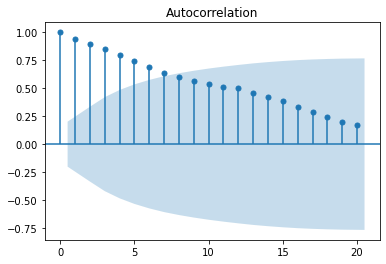

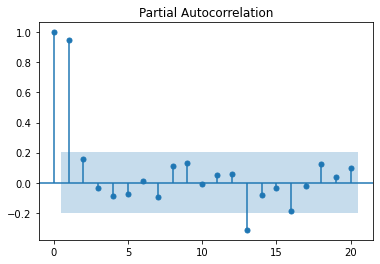

In [7]:
series = history['MedianSoldPrice_AllHomes.California']
plot_acf(series, lags=20)
plt.show()
plot_pacf(series, lags=20)
plt.show()

In [8]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [9]:
adf_test(series)

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -0.058792
p-value                         0.953391
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


According to the ACF plot and ADF test, there is an obvious trend but no seasonality for target varibale. It is also not stationary, we need to difference the data.

In [10]:
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Month')
history = history.set_index('Date')
test = test.set_index('Date')

### 1-differenced data

In [11]:
def plotts(col, acflag=40, pacflag=40):
    plt.plot(col)
    plt.title('ts plot')
    plt.xticks(rotation=90)
    plt.show()
    plot_acf(col, lags=acflag)
    plt.show()
    plot_pacf(col, lags=pacflag)

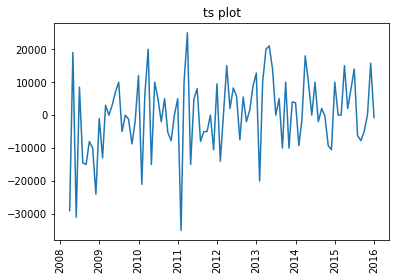

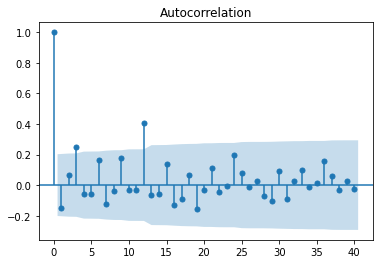

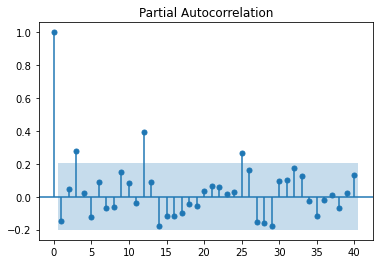

In [12]:
his_diff = history.diff().dropna()  # diff once
plotts(his_diff['MedianSoldPrice_AllHomes.California'])

In [13]:
series_diff = his_diff['MedianSoldPrice_AllHomes.California']
adf_test(series_diff)

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -3.088139
p-value                         0.027443
#Lags Used                     11.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


According to the ACF plot and ADF test, it is stationary after differencing once. We can start to fit univariate model with one-differenced data.

# Univariate Model

In [14]:
# Choosing Univariate Model based on BIC using one-differenced data
arma_order_select_ic(series_diff, max_ar=4, max_ma=4, ic='bic')

{'bic':              0            1            2            3            4
 0  2033.963390  2036.631456  2038.201996  2038.727602  2042.965276
 1  2036.256549  2041.742346  2045.028755  2043.015580  2046.377178
 2  2040.525759  2044.824289  2059.063024  2043.252818  2050.043157
 3  2037.595601  2042.138251  2058.386387  2045.331503  2058.788222
 4  2042.137814  2047.148891          NaN          NaN  2063.876547,
 'bic_min_order': (0, 0)}

We have a candidate model ARIMA(0,1,0)

In [15]:
def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1,):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                    bic=res.bic
                                    if bic < best_score:
                                        best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                except:
                                    continue
    return (best_score, best_order, best_seasonal_order)

In [16]:
# Expanding search space based on BIC using orginal data
candidate2_info = bic_sarima(series, range(0, 5), range(0, 3), range(0, 5), [0], [0], 0, D=0)
print(f'The best model is ARIMA{candidate2_info[1]} with BIC = {round(candidate2_info[0], 2)}.')

The best model is ARIMA(0, 2, 4) with BIC = 1909.91.


We have another candidate model ARIMA(0,2,4)

In [17]:
# Using auto-arima search on orignal data to see if there is more candidate
arima_auto_model = pm.auto_arima(series, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=0,              # seasonal lag
                      d=2,           # let model determine 'd'
                      seasonal=False,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2082.897, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2067.462, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2080.677, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2080.947, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2087.211, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2073.290, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2084.787, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2065.435, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2084.756, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2078.300, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2082.624, Time=0.08 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.617 seconds
                               SARIMAX Results                                
Dep. Variable:

We have last candidate model ARIMA(1,2,0)

### Comparing univariate candidate models

In [18]:
def evaluate_sarima_model(X, trend_order, seasonal_order):
    test_size = 12
    train_size = len(X) - test_size
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    return rmse

In [19]:
rmse1_arima = evaluate_sarima_model(series, (0, 1, 0), (0, 0, 0, 0))
rmse2_arima = evaluate_sarima_model(series, (0, 2, 4), (0, 0, 0, 0))
rmse3_arima = evaluate_sarima_model(series, (1, 2, 0), (0, 0, 0, 0))

100%|██████████| 12/12 [00:00<00:00, 36.53it/s]


In [20]:
pd.DataFrame([rmse1_arima, rmse2_arima,rmse3_arima], index=['cand1','cand2','cand3'],columns =['rmse'])

,rmse
cand1,8474.225628
cand2,10774.101407
cand3,10660.890740


Candidate1 ARIMA(0,1,0) has the best performance based on RMSE.

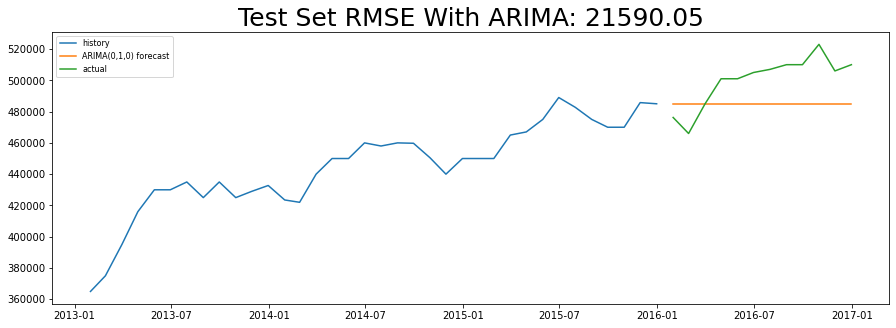

In [21]:
arima_model = sm.tsa.statespace.SARIMAX(series,order=(0,1,0), seasonal_order=(0,0,0,0))
arima_result = arima_model.fit()
arima_pred = arima_result.predict(start=len(series), end=len(series)+11)
arima_final_rmse = np.sqrt(skmetrics.mean_squared_error(df_test['Median House Price'], arima_pred))
series.index = history.index
arima_pred.index = test.index
fig = plt.figure(figsize=(15, 5))
plt.plot(series[-36:], label='history')
plt.plot(arima_pred, label='ARIMA(0,1,0) forecast')
plt.plot(test['MedianSoldPrice_AllHomes.California'],label = 'actual')
plt.title(f'Test Set RMSE With ARIMA: {round(arima_final_rmse,2)}', fontsize = 25)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [22]:
print(f'ARIMA RMSE: {arima_final_rmse}')

ARIMA RMSE: 21590.048826562048



# Multivariate  Model

In [23]:
# df_train = df_train.set_index('Date')
# df_test = df_test.set_index('Month')
# history = history.set_index('Date')
# test = test.set_index('Date')

In [24]:
def adfs(history):
    adfs = []
    for c in list(history):
        adf = adfuller(history[c], autolag='AIC')
        adfs.append(pd.Series(adf[0:2], index=['Test Statistic','p-value']))
    return pd.concat(adfs, axis=1).rename(columns={0:'MedianSoldPrice_AllHomes.California',1:'MedianMortageRate',2:'UnemploymentRate'}).T

In [25]:
adfs(history)

,Test Statistic,p-value
MedianSoldPrice_AllHomes.California,-0.058792,0.953391
MedianMortageRate,-1.822848,0.369179
UnemploymentRate,-1.481369,0.542707


Not Stationary, take one difference.

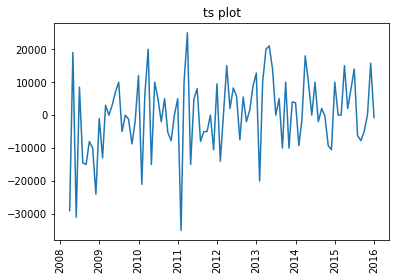

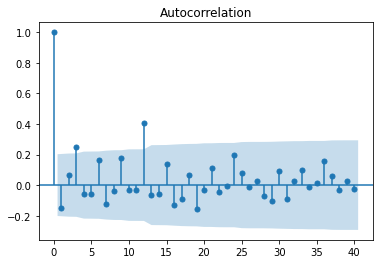

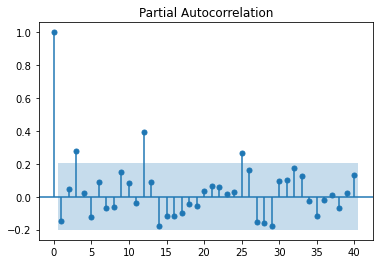

In [26]:
his_diff = history.diff().dropna() #diff once
plotts(his_diff['MedianSoldPrice_AllHomes.California'])

In [27]:
adfs(his_diff)

,Test Statistic,p-value
MedianSoldPrice_AllHomes.California,-3.088139,2.744348e-02
MedianMortageRate,-8.506971,1.195616e-13
UnemploymentRate,-1.782534,3.891669e-01


`UnemploymentRate` is still not stationary

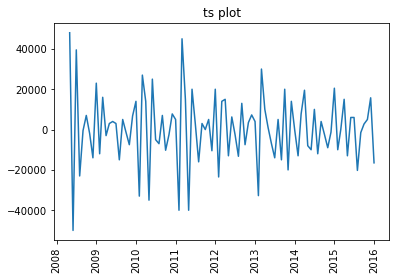

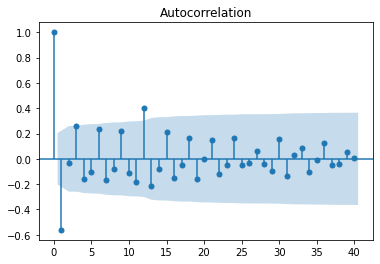

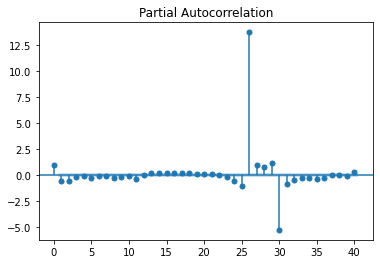

In [28]:
his_diff2 = his_diff.diff().dropna() #diff twice
plotts(his_diff2['MedianSoldPrice_AllHomes.California'])

In [29]:
adfs(his_diff2)

,Test Statistic,p-value
MedianSoldPrice_AllHomes.California,-7.390432,8.027576e-11
MedianMortageRate,-5.442476,2.756594e-06
UnemploymentRate,-12.498641,2.838908e-23


Differencing twice all variables reach stationary

### VAR model selection

In [30]:
model = VAR(his_diff2)
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Dec, 2021
Time:                     07:57:10
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    15.6699
Nobs:                     82.0000    HQIC:                   13.8781
Log likelihood:          -766.782    FPE:                    375324.
AIC:                      12.6762    Det(Omega_mle):         132579.
--------------------------------------------------------------------
Results for equation MedianSoldPrice_AllHomes.California
                                             coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------
const                                         883.491670       892.826599            0.990           0.322
L1.MedianSoldPrice_AllHomes.Calif

In [31]:
# ar(p) = 11 lag order
results.k_ar

11

In [32]:
# Input data for forecasting
forecast_input = his_diff2.values[-results.k_ar:]
forecast_input

array([[ 0.0000000e+00,  9.0000000e-02, -5.0000000e-01],
       [ 1.5000000e+04, -2.0000000e-02,  3.0000000e-01],
       [-1.3000000e+04, -1.4000000e-01,  1.0000000e-01],
       [ 6.0000000e+03,  6.0000000e-02,  1.0000000e-01],
       [ 6.0000000e+03,  1.8000000e-01,  2.0000000e-01],
       [-2.0250000e+04, -1.0000000e-01, -5.0000000e-01],
       [-1.5000000e+03,  6.0000000e-02,  2.0000000e-01],
       [ 2.7500000e+03, -1.6000000e-01, -8.8817842e-16],
       [ 5.0000000e+03,  1.0000000e-02,  8.8817842e-16],
       [ 1.5750000e+04, -4.0000000e-02,  1.0000000e-01],
       [-1.6500000e+04,  3.1000000e-01,  1.0000000e-01]])

In [33]:
# y is (p x k), p=11, k= 3
fc = results.forecast(y=forecast_input, steps=12)
dt_forecast = pd.DataFrame(fc, index=his_diff2.index[-12:], columns=his_diff2.columns + '_2d')
dt_forecast.tail(12)

,MedianSoldPrice_AllHomes.California_2d,MedianMortageRate_2d,UnemploymentRate_2d
Date,,,
2015-01-31,-5176.972757,0.085196,-0.270620
2015-02-28,10640.011267,-0.286361,-0.021778
2015-03-31,15073.990943,-0.045436,0.205227
2015-04-30,-18672.237555,0.120631,-0.194202
2015-05-31,-1470.753247,-0.061345,-0.040095
2015-06-30,2808.318728,-0.092391,-0.095834
2015-07-31,-3454.571569,0.176307,0.033616
2015-08-31,2968.919382,-0.053392,0.433036
2015-09-30,2929.735205,-0.076311,-0.222501


In [34]:
# inverting transformation
def invert_transformation(train, dt_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    dt_fc = dt_forecast.copy()
    columns = train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            dt_fc[str(col)+'_1d'] = (train[col].iloc[-1]-train[col].iloc[-2]) + dt_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        dt_fc[str(col)+'_forecast'] = train[col].iloc[-1] + dt_fc[str(col)+'_1d'].cumsum()
    return dt_fc

In [35]:
dt_results = invert_transformation(history, dt_forecast, second_diff=True)  
dt_results[['MedianSoldPrice_AllHomes.California_forecast','MedianMortageRate_forecast','UnemploymentRate_forecast']]

,MedianSoldPrice_AllHomes.California_forecast,MedianMortageRate_forecast,UnemploymentRate_forecast
Date,,,
2015-01-31,479073.027243,4.175196,4.929380
2015-02-28,483786.065753,4.174030,4.736982
2015-03-31,503573.095206,4.127429,4.749811
2015-04-30,504687.887104,4.201458,4.568437
2015-05-31,504331.925755,4.214143,4.346969
2015-06-30,506784.283135,4.134436,4.029666
2015-07-31,505782.068945,4.231037,3.745980
2015-08-31,507748.774138,4.274245,3.895329
2015-09-30,512645.214535,4.241143,3.822177


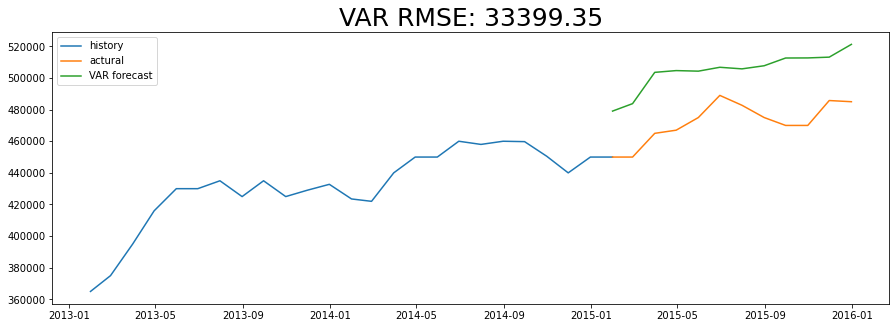

In [36]:
var_rmse = np.sqrt(skmetrics.mean_squared_error(history['MedianSoldPrice_AllHomes.California'][-12:], dt_results['MedianSoldPrice_AllHomes.California_forecast']))

plt.figure(figsize=(15,5))
plt.plot(series[-36:-11], label='history')
plt.plot(history['MedianSoldPrice_AllHomes.California'][-12:], label="actural")
plt.plot(dt_results['MedianSoldPrice_AllHomes.California_forecast'], label='VAR forecast')
plt.title(f'VAR RMSE: {round(var_rmse,2)}',fontsize =25)
plt.legend(loc=0)
plt.show();

In [37]:
var_rmse = np.sqrt(skmetrics.mean_squared_error(history['MedianSoldPrice_AllHomes.California'][-12:], dt_results['MedianSoldPrice_AllHomes.California_forecast']))
print(f'VAR RMSE: {var_rmse}')

VAR RMSE: 33399.35404203924


All the features in the data set itself should to be endogenous and influence each other, thus the VAR model should make the most sense. But RMSE was not promising and we turned to the SARIMAX model.

### SARIMAX selection

In [38]:
sc = MinMaxScaler(feature_range=(0, 1))

sc.fit(history)
train_sc = sc.transform(history)

In [39]:
#auto sarimax search without m=12
SARIMAX_model=pm.auto_arima(train_sc[:,0], # Price as endogenous
                 exogenous= train_sc[:,1:], # rest as exogenous
                 start_p=0, start_q=0, 
                 max_p=4, max_q=4, 
                 max_d=2,
                 m=12, D=1, max_P=3, max_Q=3,
                 trace=True,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1,
                out_of_sample_size= 12)

Performing stepwise search to minimize oob
 ARIMA(0,0,0)(1,1,1)[12] intercept   : OOB=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : OOB=0.011, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : OOB=0.007, Time=0.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : OOB=0.011, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : OOB=0.011, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : OOB=0.012, Time=0.34 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : OOB=0.014, Time=1.47 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : OOB=inf, Time=0.99 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : OOB=0.006, Time=0.57 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : OOB=inf, Time=1.25 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : OOB=0.043, Time=1.61 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : OOB=0.010, Time=0.26 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : OOB=0.004, Time=0.67 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : OOB=inf, Time=0.33 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : OOB=inf, Time=0.84 sec
 ARIMA(

In [40]:
y_pred = SARIMAX_model.predict_in_sample(X=train_sc[:,1:],start=history.shape[0]-12).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (gdp)

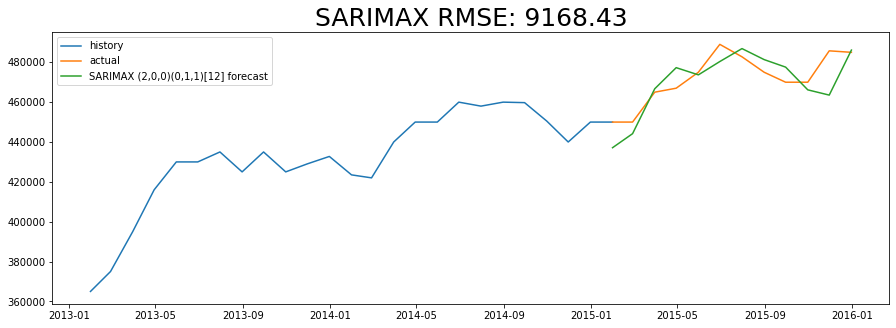

In [41]:
y_pred_series = pd.Series(y_pred_inv,index=history[-12:].index)
sarimax_rmse = np.sqrt(skmetrics.mean_squared_error(history['MedianSoldPrice_AllHomes.California'][-12:], y_pred_series))

fig = plt.figure(figsize=(15, 5))
plt.plot(series[-36:-11], label='history')
plt.plot(history['MedianSoldPrice_AllHomes.California'][-12:], label='actual')
plt.plot(y_pred_series, label='SARIMAX (2,0,0)(0,1,1)[12] forecast')
plt.legend(loc=0)
plt.title(f'SARIMAX RMSE: {round(sarimax_rmse,2)}',fontsize =25)
plt.show();

In [42]:
print(f'SARIMA RMSE: {sarimax_rmse}')

SARIMA RMSE: 9168.432163091085


Based on plot and RMSE, SARIMAX(2,0,0)(0,1,1)[12] outperform VAR model. Now we apply SARIMAX (2,0,0)(0,1,1)[12] to test set (Jan-Dec 2016)

### Test set performance

In [43]:
test_sc =sc.transform(test)
ytest_pred = SARIMAX_model.predict(n_periods=len(test_sc),X=test_sc[:,1:]).reshape(-1,1)
ytest_pred_ = np.repeat(ytest_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
ytest_pred_inv = sc.inverse_transform(ytest_pred_)[:,0]# inverset the pred and take the first column (gdp)

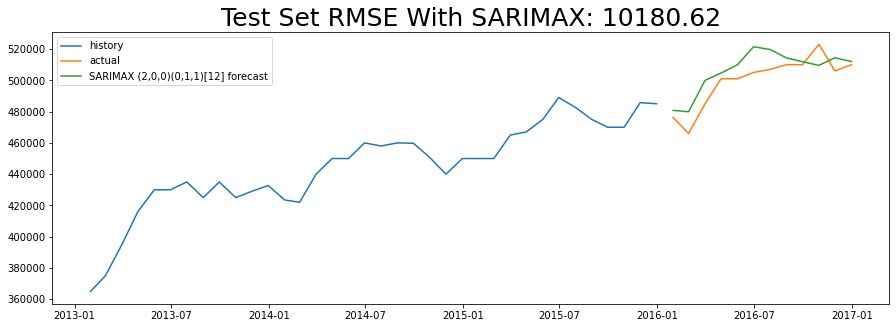

In [44]:
ytest_pred_series = pd.Series(ytest_pred_inv,index=df_test.index)
final_rmse = np.sqrt(skmetrics.mean_squared_error(df_test['Median House Price'], ytest_pred_series))

fig = plt.figure(figsize=(15, 5))
plt.plot(series[-36:], label='history')
plt.plot(df_test['Median House Price'], label='actual')
plt.plot(ytest_pred_series, label='SARIMAX (2,0,0)(0,1,1)[12] forecast')
plt.legend(loc=0)
plt.title(f'Test Set RMSE With SARIMAX: {round(final_rmse,2)}', fontsize = 25)
plt.show();

In [45]:
print(f'SARIMA RMSE: {final_rmse}')

SARIMA RMSE: 10180.620070061279
